# three-tier-geolocation - REST API Server

In [1]:
import requests
import os
# Declare constants
# REST_URL = "http://127.0.0.1:5000/uploader"

REST_URL = "http://127.0.0.1:5000"

DATASETS_PATH = "..//Datasets"

In [2]:
REQUESTED_FILE_NAME = "results.txt" 

def use_api(dataset_1p, dataset_3p, rtt_method, geolocation_method):
    output_file = os.path.join(OUTPUT_PATH, f"results_learn={dataset_1p}_test={dataset_3p}.txt")
    
    print("start:", dataset_1p, dataset_3p)
    
    dataset_1p_path = os.path.join(DATASETS_PATH, dataset_1p)
    dataset_3p_path = os.path.join(DATASETS_PATH, dataset_3p)
    
    FILE_MEASUREMENTS_1P = os.path.join(dataset_1p_path, "measurements-1party.csv")
    FILE_MEASUREMENTS_3P = os.path.join(dataset_3p_path, "measurements-3party.csv")
    FILE_SERVERS_1P = os.path.join(dataset_1p_path, "servers-1party.csv")
    FILE_SERVERS_3P = os.path.join(dataset_3p_path, "servers-3party.csv")
    FILE_DATACENTERS = os.path.join(dataset_3p_path, "datacenters.csv")
    FILE_SOLUTION = os.path.join(dataset_3p_path, "solution.csv")

    response = requests.post(REST_URL + "/rest",
                             files=[
                                 ('measurements-1party', ('measurements-1party.csv', open(FILE_MEASUREMENTS_1P, 'rb'), 'application/octet-stream')),
                                 ('servers-1party', ('servers-1party.csv', open(FILE_SERVERS_1P, 'rb'), 'application/octet-stream')),
                                 ('measurements-3party', ('measurements-3party.csv', open(FILE_MEASUREMENTS_3P, 'rb'), 'application/octet-stream')),
                                 ('servers-3party', ('servers-3party.csv', open(FILE_SERVERS_3P, 'rb'), 'application/octet-stream')),
                                 ('datacenters', ('datacenters.csv', open(FILE_DATACENTERS, 'rb'), 'application/octet-stream')),
                                 ('solution', ('solution.csv', open(FILE_SOLUTION, 'rb'), 'application/octet-stream'))
                             ],
                             data={'rtt_method': rtt_method, 'geolocation_method': geolocation_method})

    if response.status_code != 200:
        print("Error: POST received bad response code:", response.status_code)
        return

    requested_file_url = response.json()['Assets'][REQUESTED_FILE_NAME]
    print(requested_file_url)

    second_response = requests.get(requested_file_url)

    if second_response.status_code != 200:
        print("Error: GET received bad response code:", response.status_code)
        return

    with open(output_file, 'w', encoding="utf-8") as f:
        f.writelines(second_response.text)
    return second_response.text

## Use the API

### Single request

In [38]:
rtt_method = "Optimization"  # rtt_method = "Subtraction", "Optimization"
geolocation_method = "Multilateration"  # geolocation_method = "Multilateration", "Profiling"
OUTPUT_PATH = "./api-client-out/temp"  # make sure this directory exists
use_api(dataset_1p="DS-F3", dataset_3p="DS-F4", rtt_method=rtt_method, geolocation_method=geolocation_method)


start: DS-F3 DS-F4
http://127.0.0.1:5000/GetFile/tmpfo8v2fou/output/results.txt


### Multiple requests 

In [11]:
rtt_method = "Optimization"  # rtt_method = "Subtraction", "Optimization"
geolocation_method = "Profiling"  # geolocation_method = "Multilateration", "Profiling"
OUTPUT_PATH = f"api-client-out/{rtt_method}_{geolocation_method}"  # make sure this directory exists

DATASETS = ["DS-B1", "DS-F1", "DS-F2", "DS-F3", "DS-F4", ]

for d1 in DATASETS:
    for d2 in DATASETS:
        use_api(dataset_1p=d1, dataset_3p=d2, rtt_method=rtt_method, geolocation_method=geolocation_method)

start: DS-B1 DS-B1
http://127.0.0.1:5000/GetFile/tmpujw_fdsm/output/results.txt
start: DS-B1 DS-F1


KeyboardInterrupt: 

### Use one DC in each continent

In [3]:
def text_to_stats(text):
    mean_error = 0
    max_error = 0
    RMSE = 0
    success = 0
    for line in text.splitlines():
        if "Final-Geolocation Mean Error:" in line:
            parts = line.split()
            mean_error = parts[-2]
        elif "Final-Geolocation Max Error:" in line:
            parts = line.split()
            max_error = parts[-2]

        elif "Final-Geolocation RMSE Error:" in line:
            parts = line.split()
            RMSE = parts[-2]

        elif "Success rate:" in line:
            parts = line.split()
            success  = parts[-2] 
    return mean_error, max_error, RMSE, success

def clear_directories(path):
    for filename in os.listdir(path):
        file_path = os.path.join(path, filename)
        os.remove(file_path)

In [6]:
import csv
from itertools import product
import time 

rtt_method = "Optimization"  # rtt_method = "Subtraction", "Optimization"
geolocation_method = "Multilateration"  # geolocation_method = "Multilateration", "Profiling"
OUTPUT_PATH = "./api-client-out/temp"  # make sure this directory exists


def filter_first_party(combination, first_party):
    filtered_rows = []
    file_names = []
    first_party_servers = f"..//Datasets//{first_party}//servers-1party.csv"
    first_party_measurments = f"..//Datasets//{first_party}//measurements-1party.csv"
    with open(first_party_servers, mode='r') as file:
        reader = csv.reader(file)
        for row in reader: # filter the servers (only keep the append to disable)
            if len(row) > 2 and row[0] == "file" and row[2] not in combination:
                file_names.append(row[1])
                filtered_rows.append(row)
            else:
                filtered_rows.append(row)
    # make sure the dir exists
    with open('../Datasets/temp-first/servers-1party.csv', mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerows(filtered_rows)
    filtered_rows = []
    #filter the measurements (only keep the append to disable)
    with open(first_party_measurments, mode='r') as file:
        reader = csv.reader(file)
        for row in reader:
            # if row[2] not in file_names: 
            filtered_rows.append(row)
    with open('../Datasets/temp-first/measurements-1party.csv', mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerows(filtered_rows)     
    return file_names

def filter_third_party_for_one_each(third_party, combination):
    filtered_rows = []
    third_party_servers = f"..//Datasets//{third_party}//servers-3party.csv"
    third_party_measurments = f"..//Datasets//{third_party}//measurements-3party.csv"
    third_party_DC = f"..//Datasets//{third_party}//datacenters.csv"
    third_party_solution = f"..//Datasets//{third_party}//solution.csv"
    first_party_servers = f"..//Datasets//{third_party}//servers-1party.csv"
    file_names = []

    with open(first_party_servers, mode='r') as file:
        reader = csv.reader(file)
        for row in reader: # filter the servers (only keep the append to disable)
            if len(row) > 2 and row[0] == "file" and row[2] not in combination:
                file_names.append(row[1])
                filtered_rows.append(row)
            else:
                filtered_rows.append(row)

    with open(third_party_servers, mode='r') as file:
        reader = csv.reader(file)
        for row in reader: # filter the servers
            if len(row) > 1 and row[0] == "file" and row[1] in file_names:
                pass
            else:
                filtered_rows.append(row)
        with open('../Datasets/temp-third/servers-3party.csv', mode='w', newline='') as file:
            writer = csv.writer(file)
            writer.writerows(filtered_rows)
    filtered_rows = []
    with open(third_party_measurments, mode='r') as file:
        reader = csv.reader(file)
        for row in reader: # filter the measurments
            if row[2] not in file_names:
                filtered_rows.append(row)
        with open('../Datasets/temp-third/measurements-3party.csv', mode='w', newline='') as file:
            writer = csv.writer(file)
            writer.writerows(filtered_rows)
    filtered_rows = []
    with open(third_party_DC, mode='r') as file:
        reader = csv.reader(file)
        for row in reader: # add learn_only as needed
            if row[0] not in combination:
                row[-1] = "learn_only"
                row.append("")
            filtered_rows.append(row)
    with open('../Datasets/temp-third/datacenters.csv', mode='w', newline='') as file:
            writer = csv.writer(file)
            writer.writerows(filtered_rows)
    filtered_rows = []
    with open(third_party_solution,mode ='r') as file:
        reader = csv.reader(file)
        for row in reader: # filter the solution
            if row[0] not in file_names: 
                filtered_rows.append(row)
    with open('../Datasets/temp-third/solution.csv', mode='w', newline='') as file:
            writer = csv.writer(file)
            writer.writerows(filtered_rows)

def cycle_DC(dataset_1p="DS-F3", dataset_3p="DS-F4"):
    datacenters = {}
    with open(f'..//Datasets//{dataset_3p}//datacenters.csv', mode='r') as file:
        reader = csv.reader(file)
        for row in reader:
            name = row[0]
            continent = row[3]
            if continent not in datacenters:
                datacenters[continent] = []
            datacenters[continent].append(name)
    continents = list(datacenters.keys())
    combinations = list(product(*[datacenters[continent] for continent in continents]))
    results = {}
    for rtt_method in ["Subtraction"]:
        for geolocation_method in ["Profiling"]:
            total_combinations = 0
            total_mean_error = 0
            total_max_error = 0
            total_RMSE = 0
            total_success = [0,0]
            for combination in combinations:
                total_combinations += 1
                # file_names = filter_first_party(combination, dataset_1p)
                filter_third_party_for_one_each(dataset_3p, combination)
                text = use_api(dataset_1p=dataset_1p, dataset_3p="temp-third", rtt_method=rtt_method, geolocation_method=geolocation_method)
                mean_error, max_error, RMSE, success = text_to_stats(text)
                total_mean_error += float(mean_error)
                total_max_error += float(max_error)
                total_RMSE += float(RMSE)
                total_success[0] += int(success.split("/")[0])
                total_success[1] += int(success.split("/")[1])
                clear_directories("../Datasets/temp-first")
                clear_directories("../Datasets/temp-third")
            total_mean_error /= total_combinations
            total_max_error /= total_combinations
            total_RMSE /= total_combinations
            results.update({(rtt_method,geolocation_method):[total_mean_error, total_max_error, total_RMSE, total_success]})
    return results
start_time = time.time()
results = cycle_DC()
end_time = time.time()
print(f'Total Time: "{end_time-start_time}')
print(results)

start: DS-F3 temp-third
http://127.0.0.1:5000/GetFile/tmp0bon9wqm/output/results.txt
start: DS-F3 temp-third
http://127.0.0.1:5000/GetFile/tmpb8_c9b6i/output/results.txt
start: DS-F3 temp-third
http://127.0.0.1:5000/GetFile/tmp52awl84b/output/results.txt
start: DS-F3 temp-third
http://127.0.0.1:5000/GetFile/tmpah3akyd9/output/results.txt
start: DS-F3 temp-third
http://127.0.0.1:5000/GetFile/tmpy03tfmzi/output/results.txt
start: DS-F3 temp-third
http://127.0.0.1:5000/GetFile/tmp1g6zs3nv/output/results.txt
start: DS-F3 temp-third
http://127.0.0.1:5000/GetFile/tmppbvxpaj3/output/results.txt
start: DS-F3 temp-third
http://127.0.0.1:5000/GetFile/tmp7eu55krf/output/results.txt
start: DS-F3 temp-third
http://127.0.0.1:5000/GetFile/tmpnqwskfgx/output/results.txt
start: DS-F3 temp-third
http://127.0.0.1:5000/GetFile/tmpcs9c52pe/output/results.txt
start: DS-F3 temp-third
http://127.0.0.1:5000/GetFile/tmp34b77t_o/output/results.txt
start: DS-F3 temp-third
http://127.0.0.1:5000/GetFile/tmpkzscf_f8

### Changing number of forntend servers

start: DS-F2 temp-third
http://127.0.0.1:5000/GetFile/tmpg0cc385i/output/results.txt
start: DS-F2 temp-third
http://127.0.0.1:5000/GetFile/tmpsipl4w4e/output/results.txt
start: DS-F2 temp-third
http://127.0.0.1:5000/GetFile/tmpkcaz0m_i/output/results.txt
start: DS-F2 temp-third
http://127.0.0.1:5000/GetFile/tmphyug8484/output/results.txt
start: DS-F2 temp-third
http://127.0.0.1:5000/GetFile/tmp9xahpd73/output/results.txt
start: DS-F2 temp-third
http://127.0.0.1:5000/GetFile/tmpjfltja04/output/results.txt
start: DS-F2 temp-third
http://127.0.0.1:5000/GetFile/tmp583u0exl/output/results.txt
start: DS-F2 temp-third
http://127.0.0.1:5000/GetFile/tmpo8748bwu/output/results.txt
start: DS-F2 temp-third
http://127.0.0.1:5000/GetFile/tmpci2vx6ev/output/results.txt
start: DS-F2 temp-third
http://127.0.0.1:5000/GetFile/tmpe2cqkiiu/output/results.txt
start: DS-F2 temp-third
http://127.0.0.1:5000/GetFile/tmpbxjn9mcw/output/results.txt
start: DS-F2 temp-third
http://127.0.0.1:5000/GetFile/tmpzuwovnr_

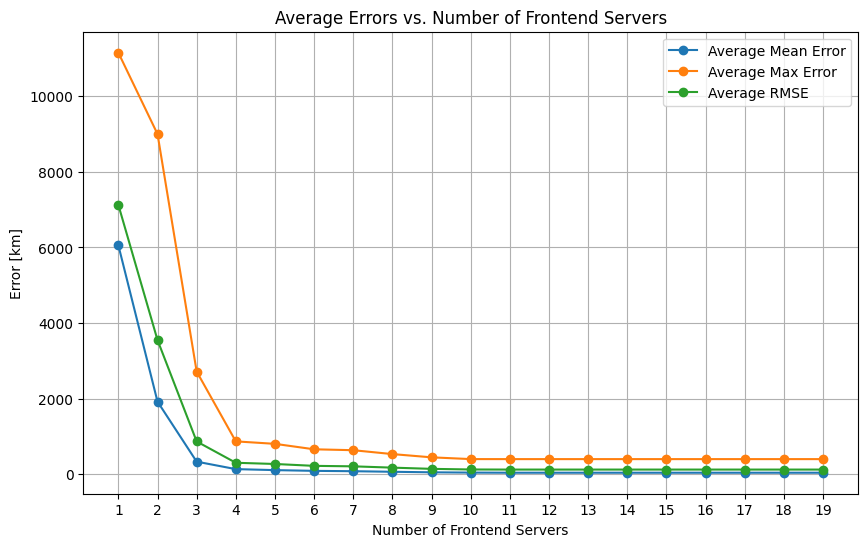

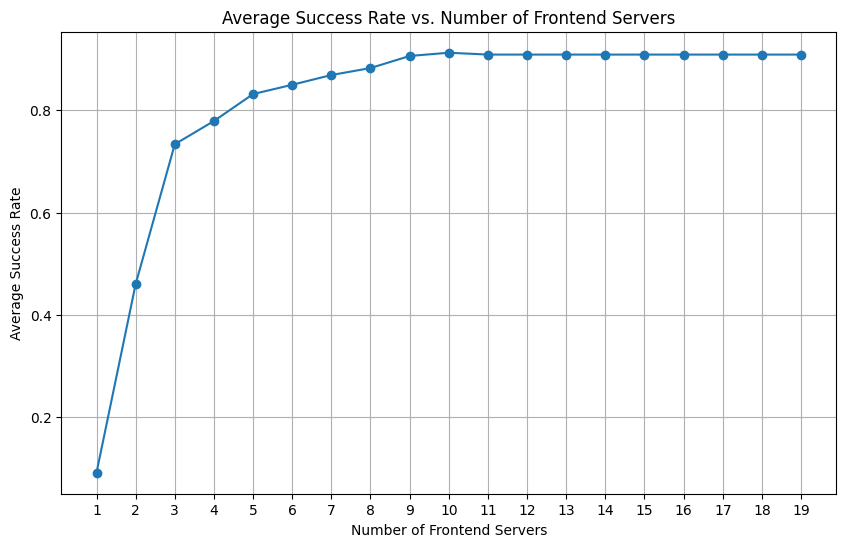

In [9]:
import random
import csv 
import matplotlib.pyplot as plt

rtt_method = "Subtraction"  # rtt_method = "Subtraction", "Optimization"
geolocation_method = "Profiling"  # geolocation_method = "Multilateration", "Profiling"
OUTPUT_PATH = "./api-client-out/temp"  # make sure this directory exists


def filter_third_party_for_changing_frontend(third_party, n):
    third_party_servers = f"..//Datasets//{third_party}//servers-3party.csv"
    third_party_measurments = f"..//Datasets//{third_party}//measurements-3party.csv"
    third_party_DC = f"..//Datasets//{third_party}//datacenters.csv"
    third_party_solution = f"..//Datasets//{third_party}//solution.csv"
    first_party_servers = f"..//Datasets//{third_party}//servers-1party.csv"
    frontend_elements = []
    with open(third_party_servers, newline='') as csvfile:
        non_frontend_lines = []
        reader = csv.reader(csvfile)
        lines = list(reader)
        frontend_lines = [(i, line) for i, line in enumerate(lines) if len(line) > 1 and line[0] == "frontend"]
        selected_frontend_lines = random.sample(frontend_lines, min(n, len(frontend_lines)))
        selected_indices = {index for index, _ in selected_frontend_lines}
        final_lines = []
        selected_frontend_elements = []
        for i, line in enumerate(lines):
            if i in selected_indices:
                final_lines.append(line)
                frontend_elements.append(line[1])  # Capture the second element
            elif i not in [tup[0] for tup in frontend_lines]:
                final_lines.append(line)

        with open('../Datasets/temp-third/servers-3party.csv', mode='w', newline='') as file:
            writer = csv.writer(file)
            writer.writerows(final_lines)

    with open(third_party_measurments, newline='') as csvfile:
        reader = csv.reader(csvfile)
        frontend_lines = []
        
        for row in reader:
            if row[1] in frontend_elements:
                frontend_lines.append(row)

        with open('../Datasets/temp-third/measurements-3party.csv', mode='w', newline='') as file:
            writer = csv.writer(file)
            writer.writerows(frontend_lines)

    with open(third_party_DC, newline='') as csvfile:
        reader = csv.reader(csvfile)
        frontend_lines = []
        for row in reader:
            frontend_lines.append(row)

        with open('../Datasets/temp-third/datacenters.csv', mode='w', newline='') as file:
            writer = csv.writer(file)
            writer.writerows(frontend_lines)

    with open(third_party_solution, newline='') as csvfile:
        reader = csv.reader(csvfile)
        
        for row in reader:
            frontend_lines.append(row)

        with open('../Datasets/temp-third/solution.csv', mode='w', newline='') as file:
            writer = csv.writer(file)
            writer.writerows(frontend_lines)
        
def changing_number_of_frontend(dataset_1p="DS-F2", dataset_3p="DS-F1",num_iteration = 100):
    results_per_n = {}
    for n in range(1,20): # 19 datacenters overall
        total_mean_error = 0
        total_max_error = 0
        total_RMSE = 0
        total_success = [0,0]
        for iteration in range(num_iteration):
            filter_third_party_for_changing_frontend(dataset_3p,n)
            text = use_api(dataset_1p=dataset_1p, dataset_3p="temp-third", rtt_method=rtt_method, geolocation_method=geolocation_method)
            mean_error, max_error, RMSE, success = text_to_stats(text)
            total_mean_error += float(mean_error)
            total_max_error += float(max_error)
            total_RMSE += float(RMSE)
            total_success[0] += int(success.split("/")[0])
            total_success[1] += int(success.split("/")[1])
        total_mean_error /= num_iteration
        total_max_error /= num_iteration
        total_RMSE /= num_iteration
        results_per_n.update({(rtt_method,geolocation_method, n):[total_mean_error, total_max_error, total_RMSE, total_success]})
    return results_per_n

results = changing_number_of_frontend()
print(results)
n_values = []
mean_errors = []
max_errors = []
RMSEs = []
successes = []
for key, value in results.items():
    n = key[2]
    total_mean_error = value[0]
    mean_errors.append(total_mean_error)
    total_max_error = value[1]
    max_errors.append(total_max_error)
    total_RMSE = value[2]
    RMSEs.append(total_RMSE)
    total_success = value[3][0] / value[3][1]
    successes.append(total_success)
    n_values.append(n)

plt.figure(figsize=(10, 6))
plt.plot(n_values, mean_errors, marker='o', linestyle='-', label = "Average Mean Error")
plt.plot(n_values, max_errors, marker='o', linestyle='-', label = "Average Max Error")
plt.plot(n_values, RMSEs, marker='o', linestyle='-', label = "Average RMSE")

# Add labels and title
plt.legend()
plt.xlabel('Number of Frontend Servers')
plt.ylabel('Error [km]')
plt.xticks(n_values)
plt.title('Average Errors vs. Number of Frontend Servers')
plt.grid(True)

# Display the plot
plt.show()


plt.figure(figsize=(10, 6))
plt.plot(n_values, successes, marker='o', linestyle='-', label = "Average success")

# Add labels and title
plt.xlabel('Number of Frontend Servers')
plt.ylabel('Average Success Rate')
plt.xticks(n_values)
plt.title('Average Success Rate vs. Number of Frontend Servers')
plt.grid(True)

# Display the plot
plt.show()
